In [1]:
import matplotlib as mpl
mpl.rcParams.update({'font.size': 12})
mpl.rcParams['axes.formatter.useoffset'] = False

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import LinearLocator, LogLocator, MaxNLocator, FormatStrFormatter
import matplotlib.patheffects as pe
import numpy as np
import copy
from cmcrameri import cm

In [2]:
import utils.load_grid as lg
from proteus.config import read_config
from proteus.utils.constants import vol_list as gas_list
from proteus.utils.plot import get_colour, latexify

### Read data

In [7]:
pgrid_dir = "data/shared/l98d_habrok2"
cases = lg.get_cases(pgrid_dir, only_completed=False)
ncases = len(cases)

In [8]:
cnums = ["%d"%int(s.split("_")[-1]) for s in cases]
stts = lg.get_statuses(pgrid_dir)
helps, hvars = lg.load_helpfiles(cases)

# Configuration variables
conf = []
for f in cases:
    conf.append( read_config(f+"/init_coupler.toml") )

print("Done")

Helpfiles: 100%|██████████| 720/720 [01:00<00:00, 11.82it/s]


Done


In [9]:
solid_thresh = float(lg.descend_get(conf[0],"params.stop.solid.phi_crit"))*1.01
print("Solidification threshold = %.3f%%"%(solid_thresh*100))

Solidification threshold = 1.010%


In [10]:
# %matplotlib widget
%matplotlib inline
# %config InlineBackend.figure_format='retina'

In [11]:
def make_atlas(x,x_lbl, y,y_lbl, dom_idx, control,
                title="",
                figscale=1.0, figsize=(5.0,4.0),
                annotate="", plot_scatter=True, plot_casenums=False, plot_controls=False,
                xscale="linear", xmult=1.0, marker_s=50,
                yscale="linear",ymult=1.0,
                interp='none', hatch_solid=False):

    # Plotting parameters
    marker_e = 'none'   # scatter edge color
    hatch_c  = 'white'  # hatch color
    hatch_t  = '//'      # hatch type
    hatch_w  = 1.0      # hatch line width

    # Gather the data
    print("Gather data")
    x_plt = np.array([], dtype=float) # x variable
    y_plt = np.array([], dtype=float) # y variable
    h_plt = np.array([], dtype=float) # hatch variable (i.e. melt fraction)
    c_plt = np.array([], dtype=str)   # case number
    z_plt = {} # gas arrays
    for gas in gas_list:
        z_plt[gas] = np.array([], dtype=float) # minor if <0, otherwise equal to vmr

    # Read each case, fill array values
    for i in range(ncases):
        keep_this = True
        for k in control.keys():
            if not (lg.descend_get(conf[i],k) == control[k]):
                keep_this = False
        if not keep_this:
            continue

        cn = cnums[i]

        # duplicates?
        this_x =  lg.descend_get(conf[i],x)
        this_y = lg.descend_get(conf[i],y)
        for j in range(len(x_plt)):
            if np.isclose(this_x, x_plt[j]) and np.isclose(this_y, y_plt[j]):
                print("WARNING: Duplicate point added to array (case=%s, x=%g, y=%g)"%(cn, this_x, this_y))

        # add point
        x_plt = np.append(x_plt, xmult*this_x)
        y_plt = np.append(y_plt, ymult*this_y)
        h_plt = np.append(h_plt, lg.access_hvars(hvars, "Phi_global", -1)[i])
        c_plt = np.append(c_plt, cn)

        # store gas
        compos = [lg.access_hvars(hvars,"%s_vmr"%g,-1)[i] for g in gas_list]
        dom_i = np.argsort(compos)[::-1][dom_idx]
        for j,g in enumerate(gas_list):
            val = 0
            if j == dom_i:
                val = compos[j]
            z_plt[g] = np.append(z_plt[g], val)

    if len(x_plt) == 0:
        print("WARNING: No data left after applying control variables!")
        return

    print("shape x:",np.shape(x_plt))
    print("shape y:",np.shape(y_plt))

    # Do interpolation on z-variables
    interp_npts = 30
    z_itp = {}
    print("Interpolate z")
    marker_e='white'
    for g in gas_list:
        _,_,xxi,yyi,zzi = lg.interp_2d(x_plt,y_plt,z_plt[g], interp_npts, method='nearest')
        z_itp[g] = zzi

    # Hatch solid cases (if allowing interpolation)
    if hatch_solid:
        print("Interpolate phi")
        _,_,_,_,hhi = lg.interp_2d(x_plt, y_plt,h_plt, interp_npts, method='linear')

    # Make the plot
    print("Plot")
    fig,ax = plt.subplots(1,1, figsize=(figsize[0]*figscale,figsize[1]*figscale))

    #    plot interpolation
    # zzi = np.clip(zzi, minz*(1+1.0e-10), maxz*(1-1.0e-10))  # avoid numerical artifacts from interpolation + cmapping
    for g in gas_list:

        zzi = z_itp[g]
        levels = [-1, 0, 1]
        colors = [(0,0,0,0), get_colour(g)]
        mappable = ax.contourf(xxi,yyi,zzi, levels=levels, colors=colors)

    #    plot hatches
    if hatch_solid:
        mpl.rcParams['hatch.linewidth'] = hatch_w
        mpl.rcParams['hatch.color'] = hatch_c
        if np.any(hhi <= solid_thresh):
            # contour hatches
            ax.contourf(xxi,yyi,hhi, alpha=0.0, levels=[-1,solid_thresh,1],hatches=[hatch_t,''], zorder=3, extend='upper')
            # contour boundary
            ax.contour( xxi,yyi,hhi, alpha=1.0, levels=[-1,solid_thresh,1],colors=[hatch_c]*3, zorder=3, extend='upper',linewidths=[hatch_w]*3)

    #    plot case numbers (debugging)
    if plot_casenums:
        for i in range(len(x_plt)):
            _c = 'white'
            ax.text(x_plt[i],y_plt[i],c_plt[i],fontsize=7, color=_c, horizontalalignment='center', verticalalignment='center', zorder=10)

    #    plot control variable text box (debugging)
    if plot_controls:
        control_str = "Control variables:\n"
        for k in control.keys():
            control_str += "  %s=%g\n" % (k,control[k])
        control_str = control_str[:-1]
        axt = ax.text(0.05, 0.95, control_str, zorder=12,
                horizontalalignment='left', verticalalignment='top', transform=ax.transAxes, fontsize=10)
        axt.set_bbox(dict(facecolor='white', alpha=0.5, linewidth=0))

    #    plot annotation
    if len(annotate) > 0:
        axt = ax.text(0.95, 0.95, annotate, zorder=12,
                horizontalalignment='right', verticalalignment='top', transform=ax.transAxes, fontsize=10)
        axt.set_bbox(dict(facecolor='white', alpha=0.5, linewidth=0))

    # legend
    x = np.median(x_plt)
    y = np.median(y_plt)
    for g in gas_list:
        ax.scatter(x,y,label=latexify(g), color=get_colour(g), zorder=-20, s=40, marker='s')
    ax.legend(loc='lower center', bbox_to_anchor=(0.5,1.0), ncols=4)

    #    finalise
    ax.set_xlabel(x_lbl)
    ax.set_ylabel(y_lbl)
    if (title != None) and (len(title) > 0):
        ax.set_title(title)

    if xscale == "symlog":
        ax.set_xscale(xscale, linthresh=np.amin(x_plt[x_plt>0]))
    else:
        ax.set_xscale(xscale)

    if yscale == "symlog":
        ax.set_yscale(yscale, linthresh=np.amin(y_plt[y_plt>0]))
    else:
        ax.set_yscale(yscale)

    return fig,ax

Gather data
shape x: (60,)
shape y: (60,)
Interpolate z
Plot


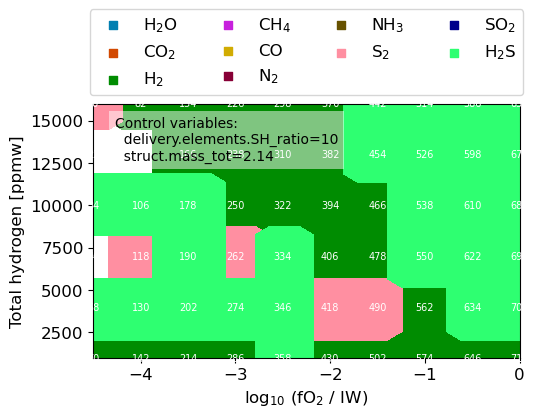

data/shared/l98d_habrok2


In [17]:
# -----------
# Reset
plt.close("all")
xmult, ymult, zmult = 1.0, 1.0, 1.0
title = ""
control = {}
marker_s = 220
annotate = ""
outpath = "output/atlas_recent.pdf"

# -----------
# Variables

x = "outgas.fO2_shift_IW";  x_lbl = "log$_{10}$ (fO$_{2}$ / IW)"; xscale="linear"
# x = "delivery.elements.H_ppmw";   x_lbl = "Hydrogen [ppmw]"; xscale="linear"

# y = "struct.corefrac";   y_lbl = "Core radius [%]"; yscale="linear"; ymult=100
y = "delivery.elements.H_ppmw";   y_lbl = "Total hydrogen [ppmw]"; yscale="linear"
# y = "orbit.dummy.H_tide";   y_lbl = "$H_{tide}$ [W kg$^{-1}$]"; yscale="symlog"

# control["delivery.elements.H_ppmw"] = 100.0
# control["outgas.fO2_shift_IW"] = 0
control["delivery.elements.SH_ratio"] = 10
control["struct.mass_tot"] = 2.14


# -----------
# Make plot
figsize       = (5,3)
plot_controls = True
plot_casenums = True
plot_scatter  = False
hatch_solid   = False
figscale      = 1.1
dom_idx       = 0

outpath       = "output/%s-atlas.pdf"%(pgrid_dir.split("/")[-2])

fig,ax = make_atlas(x,x_lbl, y,y_lbl, dom_idx, control, title=title,
         plot_scatter=plot_scatter,plot_casenums=plot_casenums, plot_controls=plot_controls,
         xscale=xscale, xmult=xmult,
         yscale=yscale, ymult=ymult, marker_s=marker_s, hatch_solid=hatch_solid,
         figscale=figscale, figsize=figsize, annotate=annotate
         )

fig.savefig(outpath, bbox_inches='tight')
plt.show()

print(pgrid_dir)